In [1]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


In [100]:
!pip install -q git+https://github.com/tensorflow/docs

In [101]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [3]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 4us/step


'C:\\Users\\krish\\.keras\\datasets\\auto-mpg.data'

In [5]:
type(dataset_path)

str

In [6]:
column_names = ["MPG", "Cyclinders" , "Displacement" , "Horsepower" , "Weight", "Acceleration" , "Model Year" , "Origin"]
raw_dataset = pd.read_csv(dataset_path , names=column_names, na_values="?", comment = "\t",
                         sep = " ", skipinitialspace=True)

In [7]:
raw_dataset.head()

,MPG,Cyclinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [47]:
dataset = raw_dataset.copy()

#### Clean the data
check weather the dataset contains na values or not


In [48]:
dataset.dropna(inplace=True) # Remove the na dataset

In [49]:
# The Origin column is categorical not a number,
# so convert to categorical
# 1 is for USA, 2 is for Europe and 3 is for Japan
dataset.Origin.nunique()

3

In [50]:
dataset.Origin = dataset.Origin.map({1:"USA", 2:"Europe", 3:"Japan"})

In [51]:
dataset = pd.get_dummies(dataset, prefix = "" , prefix_sep="")
dataset.tail()
# We can see one hot encoding

,MPG,Cyclinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


#### Split the data into train and test

In [52]:
train_dataset = dataset.sample(frac = 0.8 , random_state= 0)
test_dataset = dataset.drop(train_dataset.index)

In [53]:
# train_dataset.index

##### Inspect the data

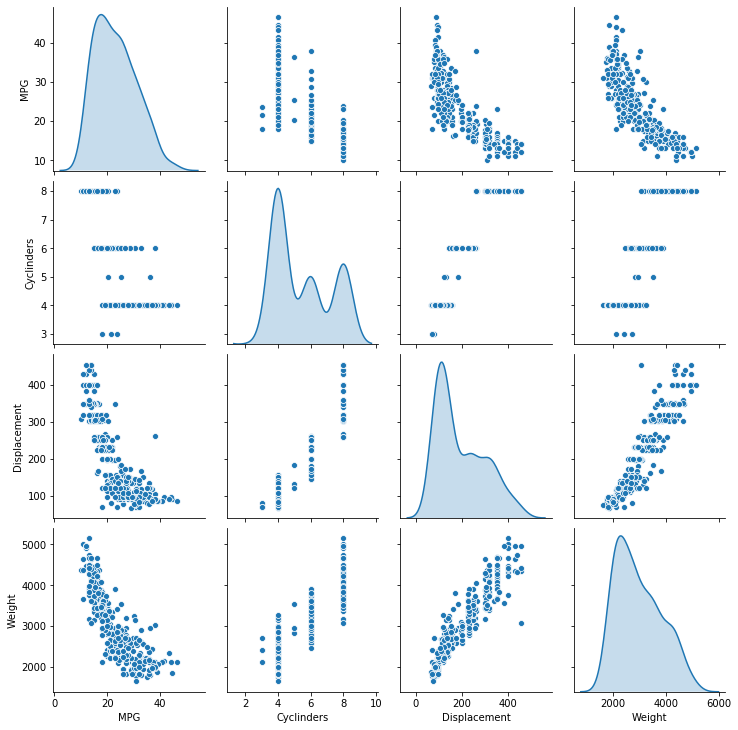

In [54]:
sns.pairplot(train_dataset[["MPG", "Cyclinders", "Displacement" , "Weight"]] , diag_kind = "kde")

#### Also look at the overall statistics

In [56]:
train_stats = train_dataset.describe()
#train_stats.pop("MPG")
train_stats = train_stats
train_stats = train_stats.transpose()

In [60]:
train_stats["mean"]

MPG               23.310510
Cyclinders         5.477707
Displacement     195.318471
Horsepower       104.869427
Weight          2990.251592
Acceleration      15.559236
Model Year        75.898089
Europe             0.178344
Japan              0.197452
USA                0.624204
Name: mean, dtype: float64

In [61]:
train_stats["std"]

MPG               7.728652
Cyclinders        1.699788
Displacement    104.331589
Horsepower       38.096214
Weight          843.898596
Acceleration      2.789230
Model Year        3.675642
Europe            0.383413
Japan             0.398712
USA               0.485101
Name: std, dtype: float64

##### Split features from labels
Seprate the target value, or "label", from the features. This label is the value that you will train the model to pridict.


In [62]:
train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop("MPG")

In [63]:
# the function also can import from dcikit learn
def norm(x):
    return (x - train_stats["mean"]) / train_stats["std"]

normed_train_data = norm(train_dataset)
normed_test_data  = norm(test_dataset)

In [67]:
normed_train_data.head()

,Acceleration,Cyclinders,Displacement,Europe,Horsepower,Japan,MPG,Model Year,USA,Weight
146,-0.379759,-0.869348,-1.009459,-0.465148,-0.784052,-0.495225,NaN,-0.516397,0.774676,-1.025303
282,0.624102,-0.869348,-0.530218,-0.465148,-0.442811,-0.495225,NaN,0.843910,0.774676,-0.118796
69,-0.738281,1.483887,1.482595,-0.465148,1.447140,-0.495225,NaN,-1.060519,0.774676,1.736877
378,-0.308055,-0.869348,-0.865687,-0.465148,-1.099044,-0.495225,NaN,1.660094,0.774676,-1.025303
331,0.875068,-0.869348,-0.942365,-0.465148,-0.994047,2.012852,NaN,1.115971,-1.286751,-1.001603


In [70]:
normed_test_data.head()

,Acceleration,Cyclinders,Displacement,Europe,Horsepower,Japan,MPG,Model Year,USA,Weight
9,-2.530891,1.483887,1.865988,-0.465148,2.234620,-0.495225,NaN,-1.604642,0.774676,1.018782
25,-0.559020,1.483887,1.578444,-0.465148,2.890853,-0.495225,NaN,-1.604642,0.774676,1.925289
28,1.054328,1.483887,1.041693,-0.465148,2.313368,-0.495225,NaN,-1.604642,0.774676,2.063931
31,-0.559020,-0.869348,-0.789008,-0.465148,-0.259066,2.012852,NaN,-1.332580,-1.286751,-0.903250
33,-0.917542,0.307270,0.351586,-0.465148,-0.127819,-0.495225,NaN,-1.332580,0.774676,-0.422150


In [68]:
# Lets remove both MPG column from train and test data sets

In [69]:
normed_test_data.drop("MPG",inplace=True)
normed_train_data.drop("MPG", inplce = True)

KeyError: "['MPG'] not found in axis"

##### Build the Model
Lets build our model. Here we'll use a Sequential model with two density connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, build_model, since we'll create a second model later

In [73]:
print(len(train_dataset.keys()))
print(len(train_dataset.columns))
print(train_dataset.columns)

9
9
Index(['Cyclinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration',
       'Model Year', 'Europe', 'Japan', 'USA'],
      dtype='object')


In [75]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation = "relu" , input_shape = [len(train_dataset.keys())]),
        layers.Dense(64, activation = "relu"),
        layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss = "mse", optimizer = optimizer,
                 metrics = ["mae" , "mse"])
    return model

In [76]:
model = build_model()

In [77]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [88]:
#normed_train_data.pop('MPG')
#normed_test_data.pop("MPG")
# will drop column MPG

In [89]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.04662719],
       [ 0.07090133],
       [-0.5761926 ],
       [-0.10886873],
       [-0.06535845],
       [-0.00835223],
       [-0.07158753],
       [-0.14163756],
       [-0.12128533],
       [ 0.06977227]], dtype=float32)

In [96]:
train_labels.head(10)

146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
257    19.4
310    38.1
328    30.0
125    20.0
108    20.0
Name: MPG, dtype: float64

#### Train the Model 
Train the model for 1000 epochs, and record the training and validation accuracy in the history object

In [102]:
EPOCHs = 1000
history = model.fit(\
                    normed_train_data, train_labels,\
                   epochs = EPOCHs, validation_split = 0.2 , verbose = 0,\
                    callbacks = [tfdocs.modeling.EpochDots()])


Epoch: 0, loss:574.0101,  mae:22.7587,  mse:574.0101,  val_loss:560.6483,  val_mae:22.4803,  val_mse:560.6483,  
....................................................................................................
Epoch: 100, loss:6.2539,  mae:1.7476,  mse:6.2539,  val_loss:8.7515,  val_mae:2.2383,  val_mse:8.7515,  
....................................................................................................
Epoch: 200, loss:5.4825,  mae:1.5731,  mse:5.4825,  val_loss:8.5303,  val_mae:2.2677,  val_mse:8.5303,  
....................................................................................................
Epoch: 300, loss:5.0629,  mae:1.5015,  mse:5.0629,  val_loss:7.8921,  val_mae:2.1548,  val_mse:7.8921,  
....................................................................................................
Epoch: 400, loss:4.4291,  mae:1.3796,  mse:4.4291,  val_loss:7.8442,  val_mae:2.1765,  val_mse:7.8442,  
..............................................................

##### Visualize the model's training progress using the stats stored in the history object.

In [104]:
hist = pd.DataFrame(history.history)
hist.head()

,loss,mae,mse,val_loss,val_mae,val_mse
0,574.010105,22.758711,574.010071,560.648295,22.480322,560.648315
1,520.831543,21.638092,520.831543,507.630335,21.343470,507.630341
2,472.634102,20.580786,472.634125,451.566711,20.079540,451.566711
3,421.361397,19.377439,421.361389,394.088722,18.679970,394.088715
4,367.130183,18.018597,367.130157,332.533248,17.047886,332.533234


In [105]:
# add a new column epoch 
hist["epoch"] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.979415,1.094931,2.979415,6.677526,1.989396,6.677526,995
996,2.955453,1.096086,2.955453,6.932441,2.024148,6.932441,996
997,2.980695,1.076753,2.980695,6.775049,1.964715,6.775049,997
998,3.015685,1.089565,3.015685,7.114086,2.030393,7.114086,998
999,2.735467,1.023478,2.735467,6.696705,2.006049,6.696705,999


In [106]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE[MPG]')

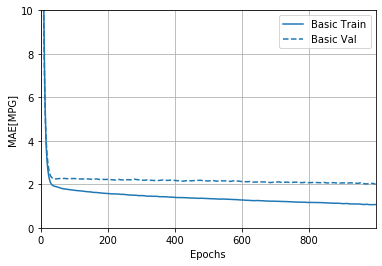

In [109]:
plotter.plot({"Basic":history}, metric = "mae")
plt.ylim([0,10])
plt.ylabel("MAE[MPG]")

Text(0, 0.5, "['MSE [MPG ^2 ]']")

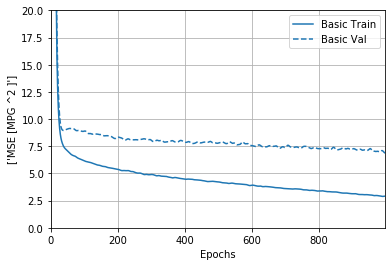

In [110]:
plotter.plot({"Basic":history}, metric="mse")
plt.ylim([0,20])
plt.ylabel(["MSE [MPG ^2 ]"])

In [111]:
loss, mae , mse  = model.evaluate(normed_test_data , test_labels , verbose=2)
print("Testing data set Mean Abs Error:",mae)

78/78 - 0s - loss: 6.9890 - mae: 2.0553 - mse: 6.9890
Testing data set Mean Abs Error: 2.055294


#### Make Predictions
Finally, predict MPG values using data in the testing set:

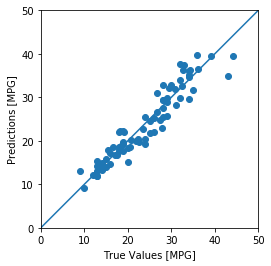

In [118]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect = "equal")
plt.scatter(test_labels , test_predictions)
plt.xlabel("True Values [MPG]")
plt.ylabel("Predictions [MPG]")

lims = [0,50] # values to print x and y axis
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims) #will create a straight forward line

In [126]:
test_predictions[:10]

array([15.83768 ,  9.119369, 13.131799, 24.476608, 17.747078, 13.326737,
       13.554897, 11.979512, 18.559282, 31.749605], dtype=float32)

In [127]:
test_labels[:10]

9     15.0
25    10.0
28     9.0
31    25.0
33    19.0
39    14.0
40    14.0
43    13.0
48    18.0
54    35.0
Name: MPG, dtype: float64

#### Lets take a look at the error distribution

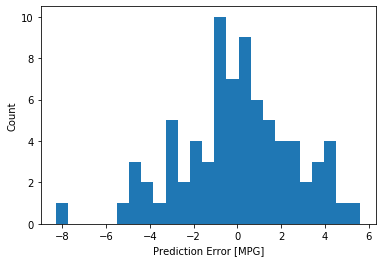

In [121]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

##### Conclusion

- Mean Squared Error(**MSE**) is a common loss function used for regression problems(different loss functions are used for classificiation problems)
- Similarly, evaluation metrics used for regression  differ from classification. A common regression metric is Mean Absolute Error **MAE**
- When numeric input data features have values with different ranges, each feature whould be scaled independently to the same range.
- If there is not much training data, one technique is to prefer a small network with network with few hidden layers to avoid overfitting.
- Early stopping is a useful technique to prevent over